# Predicting Housing Sale Prices

## Project Overview

This project involves an extensive housing dataset with data being from Cook County, Illinois. The dataset contains over 500,000 records, and has 61 features initially. I explored the data (EDA), added my own features to the existing dataset, and cleaned the data as well. After that, I fitted a linear model using sckit-learn, and created my own train-test-split function instead of importing *train-test-split*. Finally I saw the error of the model, and thought of ways to improve the model's performance at the bottom.

In [1616]:
import numpy as np
import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import train_test_split
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

In [1617]:
with zipfile.ZipFile('/Users/ethanngo/Desktop/cook_county_data.zip') as item:
    with item.open("cook_county_train.csv") as f:
        initial_data = pd.read_csv(f, index_col='Unnamed: 0')

## Quick Look at Columns/Features

In [1619]:
initial_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

Example **Description** below, where **Description** is a feature of the intial_data.

In [1621]:
initial_data['Description'][0]

'This property, sold on 09/14/2015, is a one-story houeshold located at 2950 S LYMAN ST.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

In [1622]:
initial_data.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Sale Month of Year,Sale Half of Year,Most Recent Sale,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size
0,17294100610000,203,50,2500.0,76,0.0,2.0,1.0,1.0,3.0,...,9,2,1.0,13.2,0,0.0,50,7650,"This property, sold on 09/14/2015, is a one-st...",2500.0
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,...,5,1,1.0,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0
2,25221150230000,202,210,4375.0,70,0.0,2.0,1.0,2.0,3.0,...,2,1,0.0,11.2,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0
3,10251130030000,203,220,4375.0,17,0.0,3.0,1.0,1.0,3.0,...,7,2,1.0,6.3,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0
4,31361040550000,202,120,8400.0,32,0.0,3.0,1.0,2.0,3.0,...,6,1,0.0,6.3,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0


Based on the first few values of the initial_data above, I think the granularity of each row represents a single house with varying features.

## Exploratory Data Analysis (EDA)

Perform EDA on the initial data. Below is a function *plot_distribution* to visuale the distribution of the Sale Price using both the histogram and box plot at the same time. 

In [1626]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        x=data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    plt.subplots_adjust(hspace=0)
    fig.suptitle("Distribution of " + label)

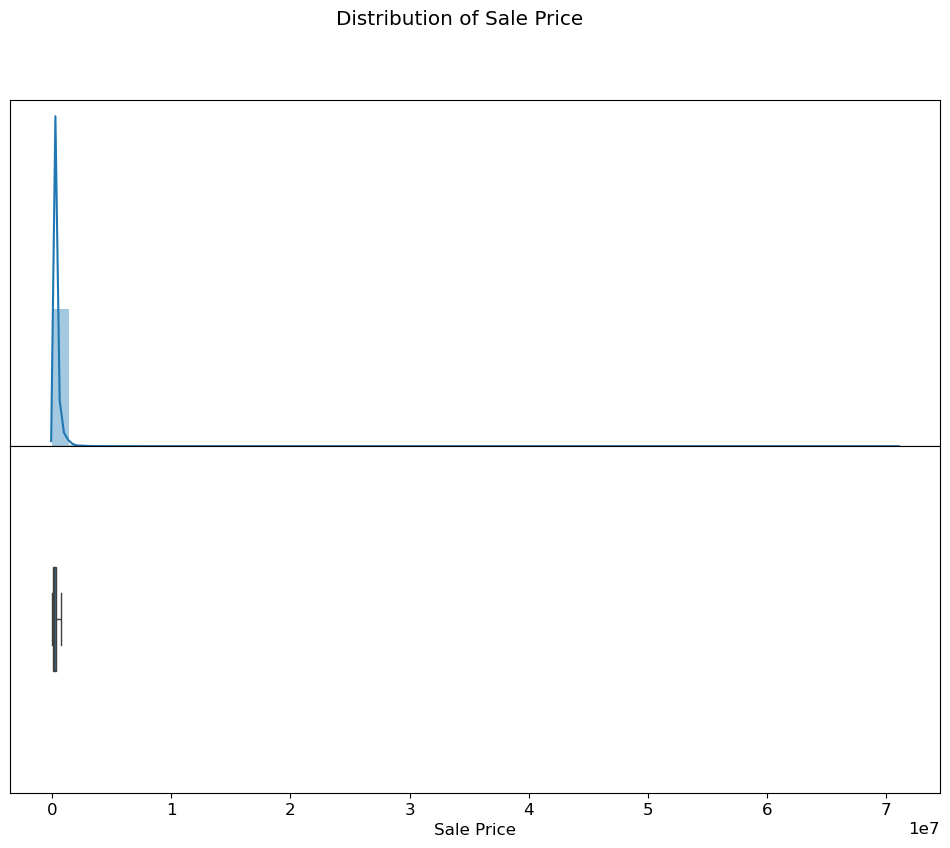

In [1627]:
plot_distribution(initial_data, label = 'Sale Price')

The distribution above is **highly skewed to the right**, probably because of some extremely expensive houses. The below cell examines the houses with prices in the range of [\\$0, \\$1,000,000]

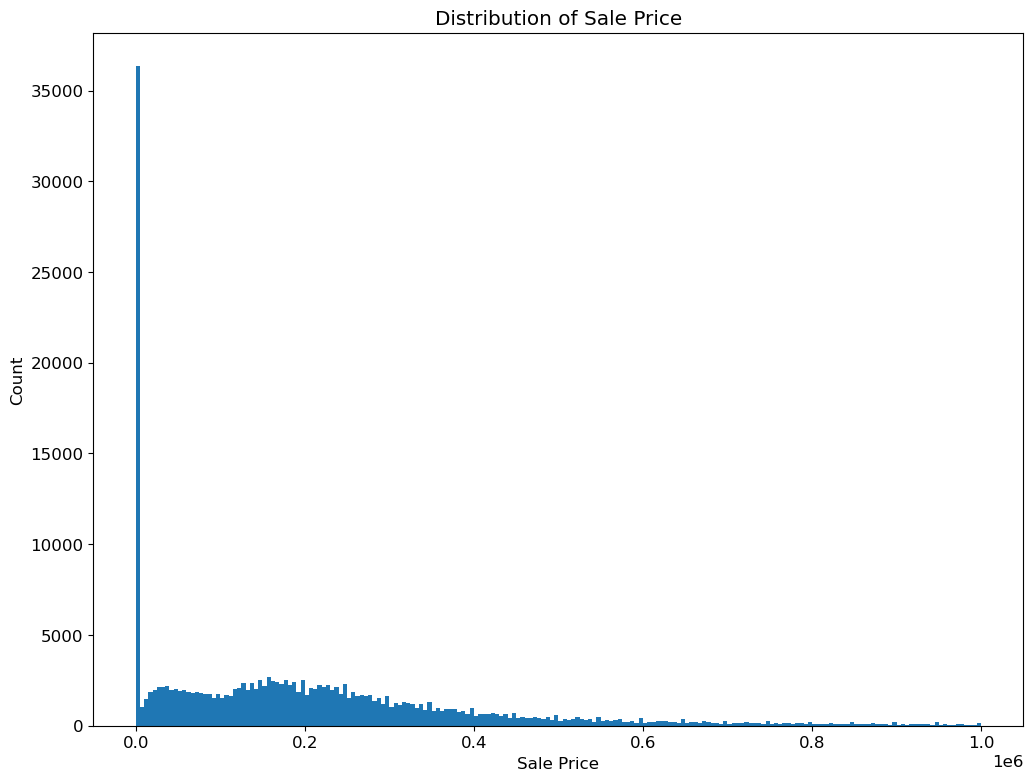

In [1629]:
no_right_outliers = initial_data[initial_data['Sale Price'] <= 1000000]['Sale Price']
plt.hist(no_right_outliers, bins=200)
plt.xlabel("Sale Price")
plt.ylabel("Count")
plt.title("Distribution of Sale Price")
plt.show()

There is a **huge spike** near the smallest bin in the distribution above, so I will now see which values are the **most common** below.

In [1631]:
initial_data['Sale Price'].value_counts()

Sale Price
1         35546
250000     1252
200000     1232
150000     1189
175000     1118
          ...  
216756        1
70050         1
358590        1
215700        1
142515        1
Name: count, Length: 14720, dtype: int64

In [1632]:
one_dollar_houses = initial_data['Sale Price'].value_counts().iloc[0]
num_houses = len(initial_data)

one_dollar_houses / num_houses

0.1735712332512989

About 17% of the houses were reported as having a sale price of \\$1, probably to act as a placeholder value. Including these data points will heavily skew the model.

## Investigate More (below)

Since a chunk of houses have a sale price of $1, I will find the top 3 most common Sale Prices that range between [0,500]. 

In [1636]:
cheap_houses = initial_data[(initial_data["Sale Price"] <= 500) & (initial_data["Sale Price"]>= 0)]
top_three = cheap_houses["Sale Price"].value_counts().head(3).index.tolist()
top_three

[1, 100, 10]

Moving forward, I will only work with houses with a Sale Price of at least $500 dollars, since anything less than that amount is unrepresentative, and overall just unrealistic. 

I will also have an upper bound to prevent outliers, such as really expensive houses that also aren't representative.

In [1638]:
fivehundredplus = len(initial_data[initial_data['Sale Price'] >= 500])
greaterthanonemillion = len(initial_data[initial_data['Sale Price'] > 1000000])
                      
#len(initial_data[initial_data['Sale Price'] > 1000000]) / len(initial_data[initial_data['Sale Price'] >= 500])
outliers_perc = greaterthanonemillion/ fivehundredplus
print(f" Greater than 1 Million: {outliers_perc}")
print(f"Number of Houses Between $500 and $1 Million: {round(outliers_perc * (fivehundredplus + lessthanonemillion))}")

 Greater than 1 Million: 0.034114520129520334
Number of Houses Between $500 and $1 Million: 5960


Since there are only around 3%, or about 5,960 houses greater than \\$1,000,000, it would definitely be reasonable to build a model with the [\\$500, \\$1,000,000] range. However, I'm going to build a model to handle the range [\\$500, infinity). In order to make the outliers useful, I will **log-transform** the data to neutralize the impact of the right outliers.

## Log-Transformation

I will now apply a log transformation to the 'Sale Price' feature, and add it as a new feature to the dataset 'training_data'.

In [1642]:
training_data = initial_data[initial_data["Sale Price"] >= 500]
training_data["Log Sale Price"] = np.log(training_data["Sale Price"])

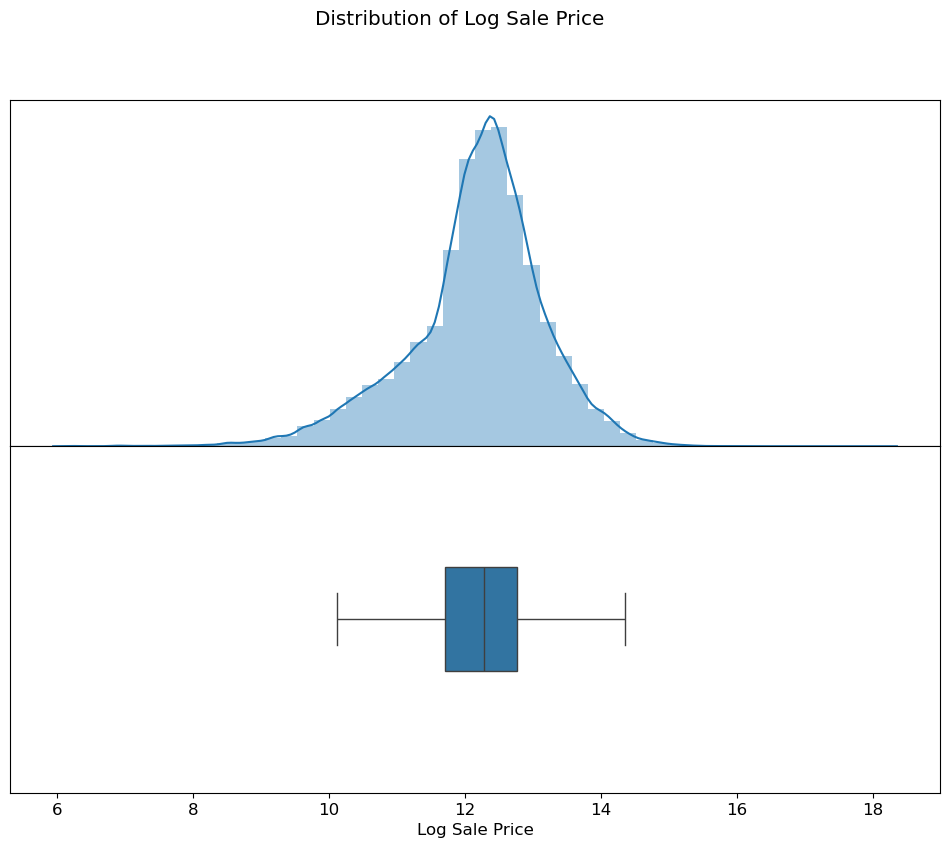

In [1643]:
plot_distribution(training_data, label = 'Log Sale Price')

The plot above is a **sanity check** and confirms that the distribution of the 'Log Sale Price' is much more uniform.

## Exploring Correlation (between Log Sale Price and Property's Total Area)

Now, I investigate if there is any correlation between 'Log Sale Price' and the total area of a house, also known as 'Building Square Feet'. Below, I will apply a log to 'Building Square Feet', and add it as another feature/column to my 'training_data' dataset.

In [1647]:
training_data['Log Building Square Feet'] = np.log(training_data["Building Square Feet"])   #addition to training dataset

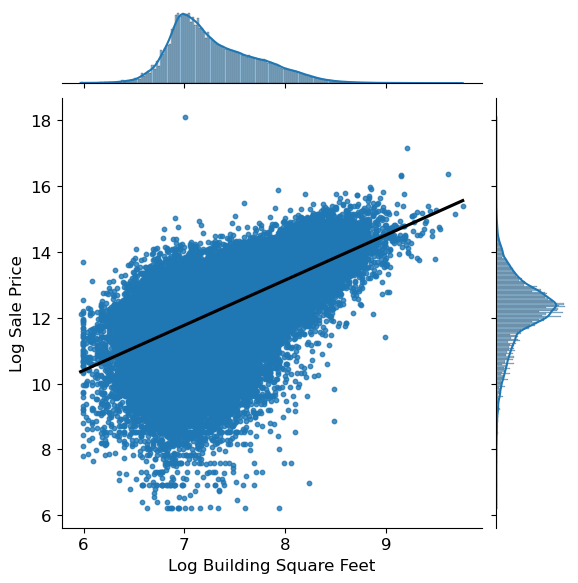

In [1648]:
sns.jointplot(data = training_data,x = 'Log Building Square Feet', y = 'Log Sale Price', kind = 'reg', scatter_kws ={'s': 10}, line_kws = {'color': 'black'}, height = 6)

## Removing Outliers

Now, I will create a function that will continue to **remove outliers** so that I can accurately create my model later on. 

In [1651]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf): 

    #lower reprents all values to negative infinity
    #upper represents all values to infinity
    
    return data[(data[variable] > lower) & (data[variable] < upper)]

In this case, I will say that an outlier is anything outside of the range between 1st and 3rd quartiles. 

In [1653]:
Q1 = training_data["Estimate (Land)"].quantile(0.25)
Q3 = training_data["Estimate (Land)"].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

#training_data.quantile(q = 0.5, axis = 0, numeric_only = True)

new_training_data = remove_outliers(training_data, "Estimate (Land)", lower, upper)

Plotting distribution below shows a much less skewed training data.

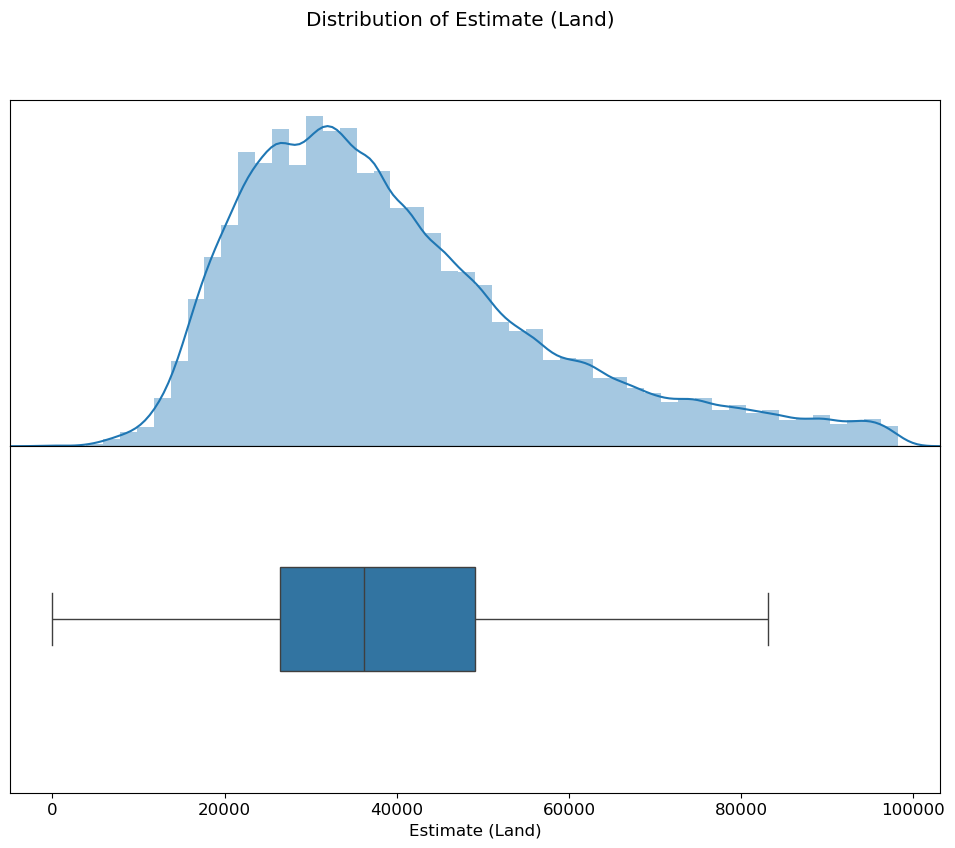

In [1655]:
plot_distribution(new_training_data, label='Estimate (Land)');

## Feature Engineering

Here, I will extract information about **bathrooms**, specifically the **number of bathrooms**, to the dataset. This information is a part of the 'Description' column. 

After that, I will createa a visualization that shows association between Bathrooms and Log Sale Price. **Violinplot** is a good choice.

In [1658]:
def add_total_bathrooms(data):
    with_rooms = data.copy()
    with_rooms["Bathrooms"] = with_rooms["Description"].str.extract(r"(\d*\.?\d+) of which are bathrooms").astype(float)
    return with_rooms

training_data = add_total_bathrooms(training_data)

Text(0.5, 1.0, 'Relationship between Bathroom Count and Log Sale Price')

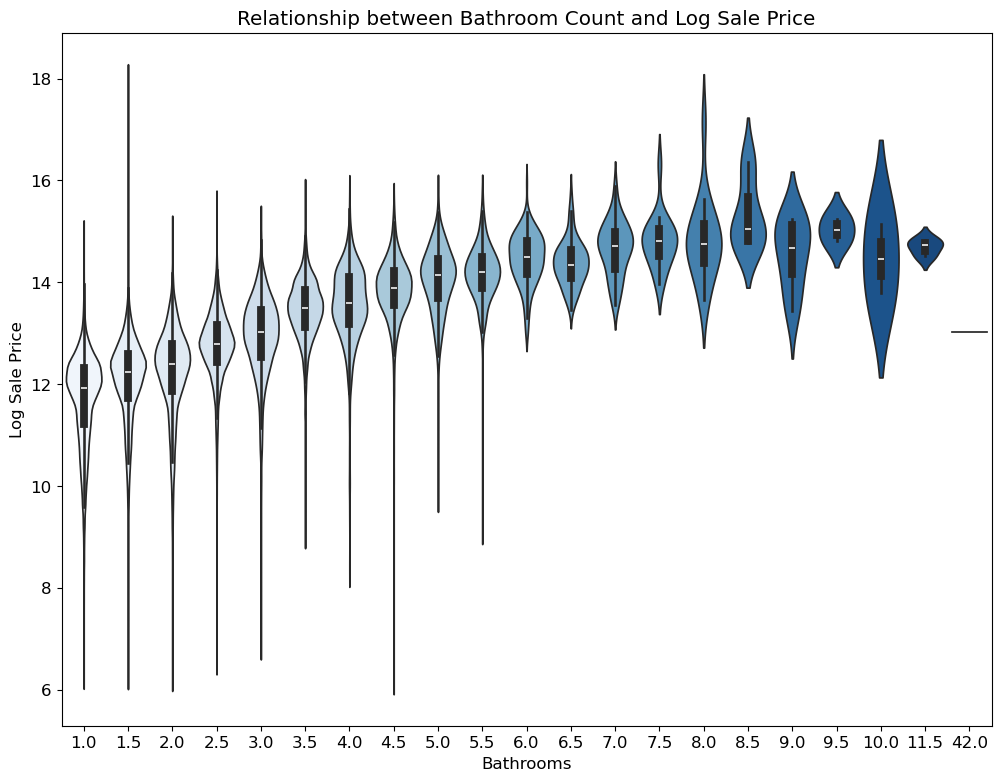

In [1659]:
sns.violinplot(data = training_data, x = 'Bathrooms', y = 'Log Sale Price', palette = "Blues")
plt.title("Relationship between Bathroom Count and Log Sale Price")

## Relationship between Neighborhood and Sale Price 

Below, I will see the number of **unique** neighborhoods that I'm dealing with. 

In [1662]:
num_neighborhoods = training_data["Neighborhood Code"].nunique()
num_neighborhoods

193

Function below to plot the relationship.

In [1664]:
def plot_categorical(neighborhoods):
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x='Neighborhood Code',
        y='Log Sale Price',
        data=neighborhoods,
        ax=axs[0],
    )

    sns.countplot(
        x='Neighborhood Code',
        data=neighborhoods,
        ax=axs[1],
    )

    axs[0].axhline(
        y=training_data['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    plt.subplots_adjust(hspace=0.01)

Since there are many neighborhoods (193), I will reduce the number of neighborhoods to the top 20 most popular neighborhoods so that my visualization won't be super dense and uninterpretable. 

The most "**popular**" neighborhoods are ones with the most property sales.

In [1666]:
top_20_neighborhood_codes = np.array(training_data["Neighborhood Code"].value_counts().head(20).index)
in_top_20_neighborhoods = training_data[training_data["Neighborhood Code"].isin(top_20_neighborhood_codes)]
in_top_20_neighborhoods.head(2)

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bathrooms
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,...,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751,1.0
4,31361040550000,202,120,8400.0,32,0.0,3.0,1.0,2.0,3.0,...,6.3,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,6.855409,1.0


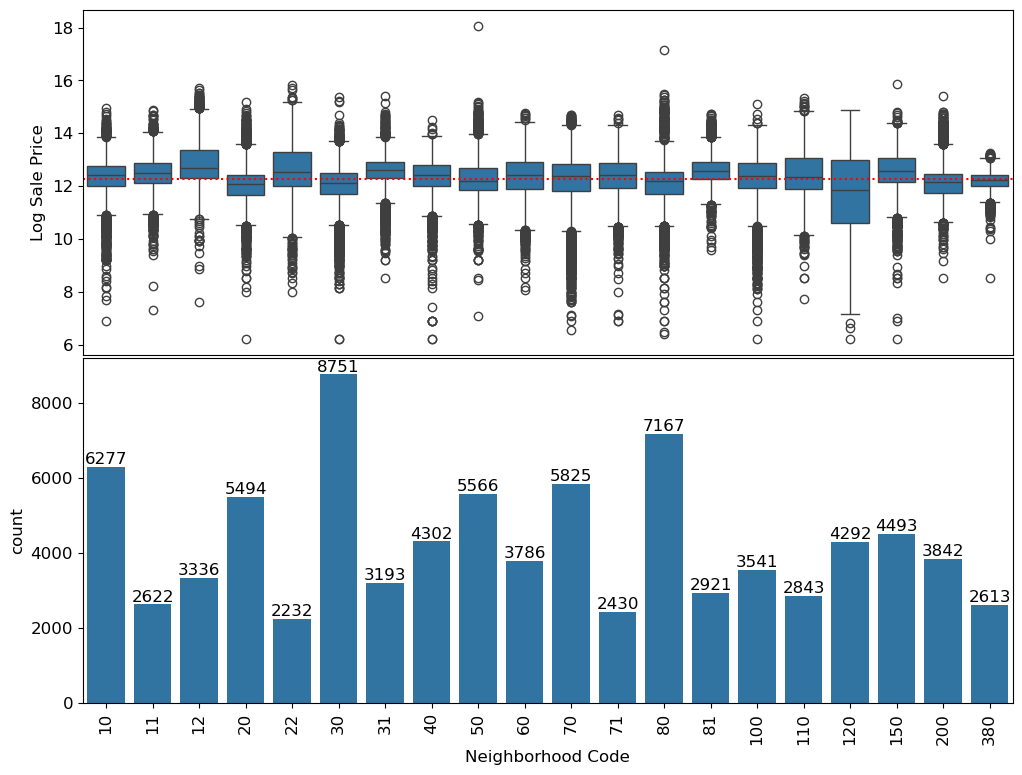

In [1667]:
plot_categorical(neighborhoods=in_top_20_neighborhoods)

Due to lack of data in some neighborhoods like in Neighborhood Code 71, I will create a function that bins neighborhoods together. Below is that function to find the most expensive neighborhoods with the highest **median 'Log Sale Price'** across all properties in those neighborhood codes. 

In [1669]:
def find_expensive_neighborhoods(data, n=3, metric=np.median):
   
    neighborhoods = data.groupby("Neighborhood Code")["Log Sale Price"].agg(metric).sort_values(ascending = False).head(n).index
    return [int(code) for code in neighborhoods]

expensive_neighborhoods = f"Top 3 expensive neighborhood codes are: {find_expensive_neighborhoods(training_data, 3, np.median)}"
print(expensive_neighborhoods)

Top 3 expensive neighborhood codes are: [44, 94, 93]


## One-hot Encoding

Here, I will look at the 'Wall Material' feature of the dataset to include categorical features into our linear model. Categorical features obviously aren't int type, hence the case of one-hot encoding later on.

Each number represents the 4 types of wall material.



1.0 - Wood

2.0 - Masonry

3.0 - Wood and Masonry

4.0 - Stucco

In [1673]:
def substitute_wall_material(data):
    
    map = {1.0 : "Wood", 2.0 : "Masonry", 3.0 : "Wood&Masonry", 4.0 : "Stucco"}
    new_data = data.replace({"Wall Material" : map})
    return new_data
    
training_data_mapped = substitute_wall_material(training_data)
training_data_mapped.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bathrooms
1,13272240180000,202,120,3780.0,71,0.0,Masonry,1.0,1.0,1.0,...,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751,1.0
2,25221150230000,202,210,4375.0,70,0.0,Masonry,1.0,2.0,3.0,...,11.2,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0,9.998798,6.810142,1.0
3,10251130030000,203,220,4375.0,17,0.0,Wood&Masonry,1.0,1.0,3.0,...,6.3,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0,12.323856,7.068172,1.5
4,31361040550000,202,120,8400.0,32,0.0,Wood&Masonry,1.0,2.0,3.0,...,6.3,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,6.855409,1.0
6,30314240080000,203,181,10890.0,37,0.0,Wood,1.0,1.0,3.0,...,10.9,1,1.0,181,37181,"This property, sold on 10/26/2017, is a one-st...",10890.0,11.512925,7.458186,1.5


## One-hot Encoder function **below**.

In [1675]:
from sklearn.preprocessing import OneHotEncoder

#
def ohe_wall_material(data):
    oh = OneHotEncoder()
    oh.fit(data[["Wall Material"]])
    oh_array = oh.transform(data[["Wall Material"]]).toarray()
    new_data = pd.DataFrame(data = oh_array, columns = oh.get_feature_names_out())
    new_data_oh = data.merge(new_data, left_index = True, right_index = True)
    return new_data_oh


training_data_ohe = ohe_wall_material(training_data_mapped)
#Line of code below will show only one-hot encoded columns that have names that begin with "Wall Material_"
training_data_ohe.filter(regex='^Wall Material_').head(10)

,Wall Material_Masonry,Wall Material_Stucco,Wall Material_Wood,Wall Material_Wood&Masonry
1,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0
6,1.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0
8,0.0,0.0,1.0,0.0
9,1.0,0.0,0.0,0.0
10,0.0,0.0,0.0,1.0
11,1.0,0.0,0.0,0.0


## Starting to Create the Linear Model

In [1677]:
with zipfile.ZipFile('/Users/ethanngo/Desktop/cook_county_data.zip') as item:
    item.extractall()

In [1678]:
training_val_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

## Preparing Data

**Training** and **Validation** DataSets

In [1681]:
np.random.seed(1337)

def train_val_split(data):

    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)

    split_index = int(data_len * .8)
    train_indices = shuffled_indices[:split_index]     # training data is %80 of the data
    validation_indices = shuffled_indices[split_index:]     # validation data is %20 of the data
        
    train = data.iloc[train_indices]
    validation = data.iloc[validation_indices]
   
    return train, validation
train, validation = train_val_split(training_val_data)

Below is a "**pipeline**" function that calls a few functions all at once, and ensures that all feature engineering is applied to all data. 

In [1683]:
def log_transform(df, column):    #helper function for the "pipeline" function below
    df = df.copy()
    df["Log " + column] = np.log(df[column])
    return df

def feature_engine_simple(data):
    # Remove outliers
    data = remove_outliers(data, 'Sale Price', lower=499)
    # Create Log Sale Price column
    data = log_transform(data, 'Sale Price')
    # Create Bathrooms column
    data = add_total_bathrooms (data)
    # Select X and Y from the full data
    X = data[['Bathrooms']]
    Y = data['Log Sale Price']
    return X, Y

full_data = pd.read_csv("cook_county_train.csv")

np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)
X_train_m1_simple, Y_train_m1_simple = feature_engine_simple(train_m1)
X_valid_m1_simple, Y_valid_m1_simple = feature_engine_simple(valid_m1)

display(X_train_m1_simple.head())
display(Y_train_m1_simple.head())

,Bathrooms
130829,2.5
193890,1.0
30507,1.5
91308,1.5
131132,2.5


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

Below is an **alternate** way to build the pipeline by using **pd.DataFrame.pipe**

In [1685]:
def feature_engine_pipe(data, pipeline_functions, prediction_col):
    #Process the data for a guided model
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col])
    Y = data.loc[:, prediction_col]
    return X, Y

Down below, I will do a few things, such as remove outliers and apply log transformations, in the pipeline and assign the final training data and validation data for both models to the following set of variables:

**First Model**: X_train_m1, *Y_train_m1*, X_valid_m1, *Y_valid_m1*

**Second Model**: X_train_m2, *Y_train_m2*, X_valid_m2, *Y_valid_m2*

The equation of the models is below:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bathrooms})
$$


$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bathrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

**First Model**

In [1688]:
full_data = pd.read_csv("cook_county_train.csv")

np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)

def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

m1_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'column': 'Sale Price'}),
    (add_total_bathrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bathrooms'], None)
]

X_train_m1, Y_train_m1 = feature_engine_pipe(train_m1, m1_pipelines, 'Log Sale Price')
X_valid_m1, Y_valid_m1 = feature_engine_pipe(valid_m1, m1_pipelines, 'Log Sale Price')


display(X_train_m1.head())
display(Y_train_m1.head())

,Bathrooms
130829,2.5
193890,1.0
30507,1.5
91308,1.5
131132,2.5


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

**Second Model**

In [1690]:
np.random.seed(1337)

train_m2, valid_m2 = train_val_split(full_data)

m2_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'column': 'Sale Price'}),
    (log_transform, None, {'column': 'Building Square Feet'}),
    (add_total_bathrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bathrooms', 'Log Building Square Feet'], None)
]

X_train_m2, Y_train_m2 = feature_engine_pipe(train_m2, m2_pipelines, 'Log Sale Price')
X_valid_m2, Y_valid_m2 = feature_engine_pipe(valid_m2, m2_pipelines, 'Log Sale Price')


display(X_train_m2.head())
display(Y_train_m2.head())

,Bathrooms,Log Building Square Feet
130829,2.5,7.870166
193890,1.0,7.002156
30507,1.5,6.851185
91308,1.5,7.228388
131132,2.5,7.990915


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

## Linear Regression

In [1692]:
linear_model_m1 = lm.LinearRegression(fit_intercept=True)
linear_model_m2 = lm.LinearRegression(fit_intercept=True)

In [1693]:
# the 1st model
linear_model_m1.fit(X_train_m1, Y_train_m1)
# the fitted and predicted values of Log Sale Price for 1st model
Y_fitted_m1 = linear_model_m1.predict(X_train_m1)
Y_predicted_m1 = linear_model_m1.predict(X_valid_m1)

# the 2nd model
linear_model_m2.fit(X_train_m2, Y_train_m2)
# the fitted and predicted values of Log Sale Price for 2nd model
Y_fitted_m2 = linear_model_m2.predict(X_train_m2)
Y_predicted_m2 = linear_model_m2.predict(X_valid_m2)

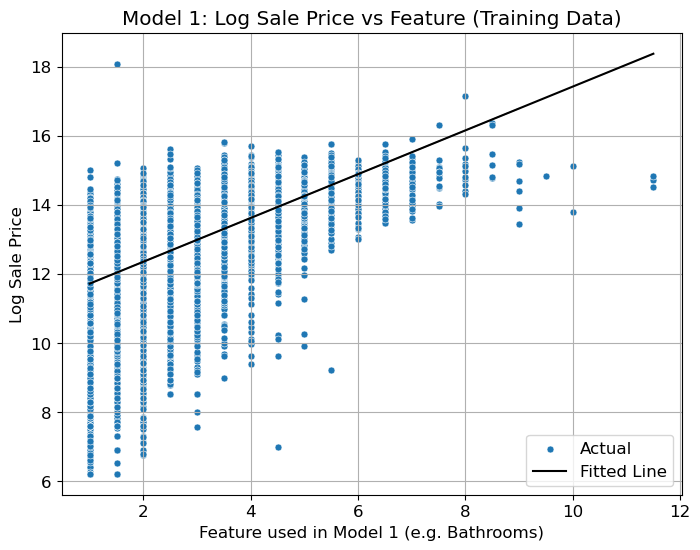

In [1694]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_m1.squeeze(), y=Y_train_m1, label="Actual", s=25)
sns.lineplot(x=X_train_m1.squeeze(), y=Y_fitted_m1, color='black', label="Fitted Line")
plt.title("Model 1: Log Sale Price vs Feature (Training Data)")
plt.xlabel("Feature used in Model 1 (e.g. Bathrooms)")
plt.ylabel("Log Sale Price")
plt.legend()
plt.grid(True)
plt.show()

## Evaluating the Model

In [1696]:
def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

My model 2's performance can be assessed with the **plot of residuals** below. As you can see, it is regressive.

Text(0, 0.5, 'Residuals')

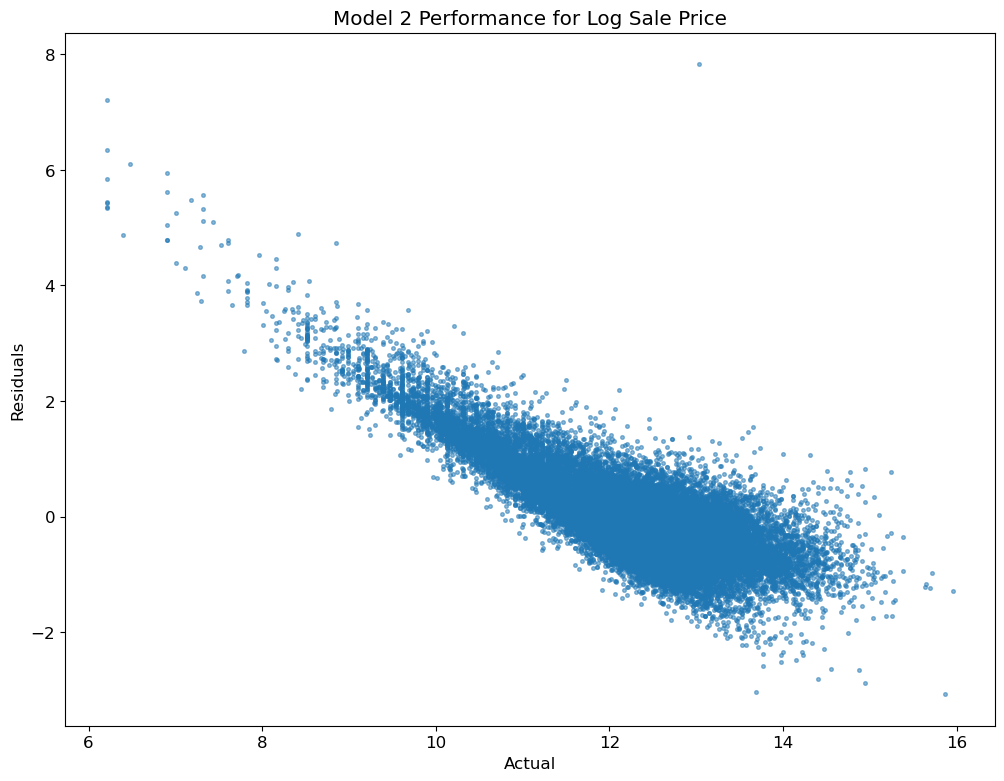

In [1698]:
plt.scatter(Y_valid_m2, Y_predicted_m2 - Y_valid_m2, s = 7, alpha = 0.5)
plt.title("Model 2 Performance for Log Sale Price")
plt.xlabel("Actual")
plt.ylabel("Residuals")

## K-fold crossvalidation

Here, I use **k-fold cross validation** to more accurately evaluate my model.

In [1701]:
from sklearn.model_selection import KFold


def compute_CV_error(X_train, Y_train, folds=10):
    '''
    1. Split the training data into `k` subsets.
    2. Fit a model for each subset.
    3. Compute the MSE on that subset (the validation set).
    4. Return a list of "k" RMSEs.
    '''
    model = lm.LinearRegression(fit_intercept=True)
    kf = KFold(n_splits=folds)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # Split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        
        # Compute the RMSE on the validation split
        error = rmse(model.predict(split_X_valid), split_Y_valid)
        validation_errors.append(error)
    return validation_errors

Here below, I get the RSMEs from Model 1, and then Model 2.

In [1703]:
#np.random.seed(1337)

cv_m1 = compute_CV_error(X_train_m1, Y_train_m1, folds = 4)
cv_m2 = compute_CV_error(X_train_m2, Y_train_m2, folds = 4)
print(f"The RMSE errors for 4-fold cross-validation on Model 1 were: {cv_m1}")
print(f"The RMSE errors for 4-fold cross-validation on Model 2 were: {cv_m2}")

The RMSE errors for 4-fold cross-validation on Model 1 were: [0.8449406074214761, 0.8509652392813479, 0.8397198961325061, 0.8390533114490786]
The RMSE errors for 4-fold cross-validation on Model 2 were: [0.798629644782871, 0.8034792940524004, 0.7947882168346345, 0.7939635404119822]


# Making my Own Model Now

Here is the **process of building my own model**, which includes some feature engineering, fitting and evaluating the model, and prediction. I will predict Log Sale Price for the test data, and de-log the log values. Then, I compute test RSME.

In [1706]:
selected_features = ['High Quality', 'Log Building Square Feet', 'Has Garage', 'Near Road', 
 'Age Squared', 'In Floodplain', 'Has Central Air', 'Age', 'Good Repair', 
 'Has Full Basement', 'Square Feet per Room', 'Low Value Neighborhood', 
 'Bathrooms', 'High Value Neighborhood', 'SqFt_per_Age', 'Square Feet per Age', 
 'Airport Noise', 'New Building', 'Log Land Square Feet']

Below is another "pipeline" function, which is conceptually similar to the one I made cell 1230.

In [1708]:
def feature_engine_final(data, is_test_set=False):
    if not is_test_set:
        neighborhood_price_medians = data.groupby('Neighborhood Code')['Sale Price'].median()
        high_value_neighborhoods = neighborhood_price_medians.sort_values(ascending=False).head(8).index.tolist()
        low_value_neighborhoods = neighborhood_price_medians.sort_values(ascending=True).head(8).index.tolist()
        data['Log Sale Price'] = np.log(data['Sale Price'])
        data = data[(data['Sale Price'] > 5000) & (data['Sale Price'] < 2500000)]
    else:
        high_value_neighborhoods = [2, 6, 9, 14, 18, 22, 27, 35]
        low_value_neighborhoods = [50, 52, 54, 56, 58, 60, 62, 64]
    
    data['Bathrooms'] = data['Description'].str.extract(r'(\d+)\s+bathrooms', expand=False).astype(float)
    data['Bathrooms'] = data['Bathrooms'].fillna(1.0)
    data['High Value Neighborhood'] = data['Neighborhood Code'].isin(high_value_neighborhoods).astype(int)
    data['Low Value Neighborhood'] = data['Neighborhood Code'].isin(low_value_neighborhoods).astype(int)
    data['Bathrooms'] = data['Bathrooms'].fillna(data['Description'].str.extract(r'(\d+)\s+BA', expand=False).astype(float))
    data['Log Building Square Feet'] = np.log(data['Building Square Feet'].clip(lower=50))
    data['Age'] = data['Age'].fillna(15)
    data['Age'] = data['Age'].clip(upper=120)
    data['Land Square Feet'] = data['Land Square Feet'].replace(0, np.nan)
    data['Land Square Feet'] = data['Land Square Feet'].fillna(data['Land Square Feet'].median())
    data['Log Land Square Feet'] = np.log(data['Land Square Feet'].clip(lower=50))
    data['Age Squared'] = data['Age']**2
    data['New Building'] = (data['Age'] < 5).astype(int)
    township_dummies = pd.get_dummies(data['Town Code'], prefix='Township', drop_first=True)
    data = pd.concat([data, township_dummies], axis=1)
    wall_material_mapping = {1: 'Wood', 2: 'Masonry', 3: 'Wood&Masonry', 4: 'Stucco'}
    data['Wall Material'] = data['Wall Material'].fillna(2)
    data['Wall Material'] = data['Wall Material'].map(wall_material_mapping)
    wall_dummies = pd.get_dummies(data['Wall Material'], prefix='Wall', drop_first=True)
    data = pd.concat([data, wall_dummies], axis=1)
    data['Has Central Air'] = (data['Central Air'] == 1).astype(int)
    data['Has Garage'] = ((data['Garage 1 Size'] != 7) & (data['Garage 1 Size'].notna())).astype(int)

    data['Has Full Basement'] = (data['Basement'] == 1).astype(int)
    data['Has Finished Basement'] = ((data['Basement Finish'] == 1) | (data['Basement Finish'] == 2)).astype(int)

    data['SqFt_per_Bath'] = data['Building Square Feet'] / data['Bathrooms'].clip(lower=1)
    data['SqFt_per_Age'] = data['Building Square Feet'] / (data['Age'] + 1)

    data['Near Road'] = data['Road Proximity'].fillna(0).astype(int)
    data['Airport Noise'] = data['O\'Hare Noise'].fillna(0).astype(int)
    data['In Floodplain'] = data['Floodplain'].fillna(0).astype(int)

    data['High Quality'] = (data['Construction Quality'] == 1).astype(int)
    data['Good Repair'] = (data['Repair Condition'] == 1).astype(int)

    data['Square Feet per Room'] = data['Building Square Feet'] / data['Bathrooms'].clip(lower=1)
    data['Square Feet per Age'] = data['Building Square Feet'] / (data['Age'] + 1)

    for col in wall_dummies.columns:
        selected_features.append(col)
    for col in township_dummies.columns:
        selected_features.append(col)
    
    if is_test_set:
        X = data[selected_features]
        return X
    else:
        X = data[selected_features]
        Y = data['Log Sale Price']
        return X, Y

check_rmse_threshold = run_linear_regression_test_optim(lm.LinearRegression(fit_intercept=True), feature_engine_final, 'cook_county_train.csv', None, False)
print("Current training RMSE:", check_rmse_threshold.loss)
print("You can check your grade for your prediction as per the grading scheme outlined at the start of Question 5")

Current training RMSE: 0.5549110733796595
You can check your grade for your prediction as per the grading scheme outlined at the start of Question 5


## Sale Price Comparisons

Below is the **predicted** *vs.* **actual values**.

In [1711]:
train_df = pd.read_csv('cook_county_train.csv')
X, Y_true = feature_engine_final(train_df)
model = lm.LinearRegression(fit_intercept=True)
model.fit(X, Y_true)
Y_pred = model.predict(X)

In [1712]:
preds_df = pd.DataFrame({'True Log Sale Price' : Y_true, 'Predicted Log Sale Price' : Y_pred, 
                         'True Sale Price' : np.e**Y_true, 'Predicted Sale Price' : np.e**Y_pred})
preds_df.head()

,True Log Sale Price,Predicted Log Sale Price,True Sale Price,Predicted Sale Price
1,12.560244,12.271518,285000.0,213526.909407
2,9.998798,10.829144,22000.0,50470.475428
3,12.323856,12.919524,225000.0,408204.712926
4,10.025705,10.787107,22600.0,48392.809398
6,11.512925,11.183007,100000.0,71898.224878


Below is **two subsets of data** to find the lowest and highest intervals for true sale prices.

In [1714]:
min_Y_true, max_Y_true = np.round(np.min(Y_true), 1) , np.round(np.max(Y_true), 1)
median_Y_true = np.round(np.median(Y_true), 1)
cheap_df = preds_df[(preds_df['True Log Sale Price'] >= min_Y_true) & (preds_df['True Log Sale Price'] <= median_Y_true)]
expensive_df = preds_df[(preds_df['True Log Sale Price'] > median_Y_true) & (preds_df['True Log Sale Price'] <= max_Y_true)]

print(f'\nThe lower interval contains houses with true sale price ${np.round(np.e**min_Y_true)} to ${np.round(np.e**median_Y_true)}')
print(f'The higher interval contains houses with true sale price ${np.round(np.e**median_Y_true)} to ${np.round(np.e**max_Y_true)}\n')


The lower interval contains houses with true sale price $4915.0 to $219696.0
The higher interval contains houses with true sale price $219696.0 to $2421748.0



Below, I compute the RSME of my model's predictions of *cheap_df* and *expensive_df* separately. Then I compute the **proportion** of houses where the model **overestimates 'Sale Price'**. 

In [1716]:
rmse_cheap = rmse(cheap_df['Predicted Sale Price'],cheap_df['True Sale Price'])
rmse_expensive = rmse(expensive_df['Predicted Sale Price'],expensive_df['True Sale Price'])

prop_overest_cheap = np.sum(cheap_df['Predicted Sale Price'] > cheap_df['True Sale Price']) /len(cheap_df)
prop_overest_expensive = np.sum(expensive_df['Predicted Sale Price'] > expensive_df['True Sale Price']) / len(expensive_df)

print(f"The RMSE for properties with log sale prices in the interval {(min_Y_true, median_Y_true)} is {np.round(rmse_cheap)}")
print(f"The RMSE for properties with log sale prices in the interval {(median_Y_true, max_Y_true)} is {np.round(rmse_expensive)}\n")
print(f"The percentage of overestimated values for properties with log sale prices in the interval {(min_Y_true, median_Y_true)} is {np.round(100 * prop_overest_cheap, 2)}%")
print(f"The percentage of overestimated values for properties with log sale prices in the interval {(median_Y_true, max_Y_true)} is {np.round(100 * prop_overest_expensive, 2)}%")

The RMSE for properties with log sale prices in the interval (8.5, 12.3) is 68325.0
The RMSE for properties with log sale prices in the interval (12.3, 14.7) is 196239.0

The percentage of overestimated values for properties with log sale prices in the interval (8.5, 12.3) is 58.0%
The percentage of overestimated values for properties with log sale prices in the interval (12.3, 14.7) is 33.41%


## A Deeper Look Across Intervals

The intervals I have above are pretty broad, so here I will understand how RSME and proportion of houses overestimated vary across different intervals of 'Log Sale Price'. The two functions below compute RSME and proportion of overestimated home prices for ANY interval of home prices.

In [1719]:
def rmse_interval(df, start, end):
    subset_df = df[(df['True Log Sale Price'] <= end) & (df['True Log Sale Price'] >= start)]
    rmse_subset = rmse(subset_df['Predicted Sale Price'], subset_df['True Sale Price'])
    return rmse_subset
    
def prop_overest_interval(df, start, end):
    subset_df = df[(df['True Log Sale Price']>= start) & (df['True Log Sale Price']<= end)]
    if subset_df.shape[0] == 0:
        return -1

    prop_subset = np.sum(subset_df['Predicted Sale Price']> subset_df['True Sale Price'])/ len(subset_df)
    return prop_subset

Using the functions above, I will create visualizations of how RMSE and proportion of overestimated houses vary for different intervals.

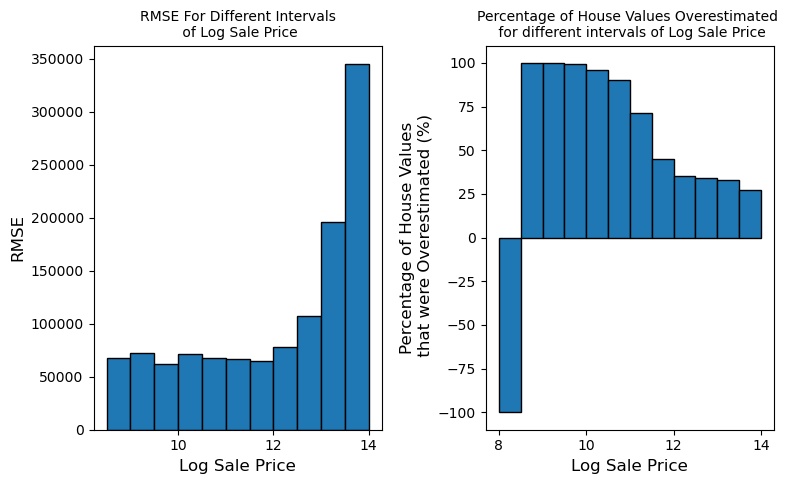

In [1721]:
# RMSE plot
plt.figure(figsize = (8,5))
plt.subplot(1, 2, 1) 
rmses = []
for i in np.arange(8, 14, 0.5):
    rmses.append(rmse_interval(preds_df, i, i + 0.5))
plt.bar(x = np.arange(8.25, 14.25, 0.5), height = rmses, edgecolor = 'black', width = 0.5)
plt.title('RMSE For Different Intervals\n of Log Sale Price', fontsize = 10)
plt.xlabel('Log Sale Price')
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.ylabel('RMSE')

# Overestimation plot  
plt.subplot(1, 2, 2)
props = []
for i in np.arange(8, 14, 0.5):
    props.append(prop_overest_interval(preds_df, i, i + 0.5) * 100) 
plt.bar(x = np.arange(8.25, 14.25, 0.5), height = props, edgecolor = 'black', width = 0.5)
plt.title('Percentage of House Values Overestimated \n for different intervals of Log Sale Price', fontsize = 10)
plt.xlabel('Log Sale Price')
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.ylabel('Percentage of House Values\n that were Overestimated (%)')

plt.tight_layout()
plt.show()

The *left plot* helps in evaluating the fairness of the model's predictions. If the RMSE is higher for lower-priced properties, it indicates that **the model tends to overvalue cheaper properties while undervaluing more expensive ones**. 

The *right plot* conveys the overestimation for different intervals of house prices. The single bar that has an x-value around 8 is negative because the sale prices were not overestimated at all. **For context, *Log* Sale Price = 8 --> Sale Price = 100,000,000**

# Project Recap

### Tools and Techniques

This project involved **feature engineering, exploratory data analysis (EDA), handling outliers, cross-validation, modeling, model evaluation, plotting, one-hot encoding, and more**.

### Room for Improvement

With a training RMSE of 0.55, there's definitely room for **improvement**. Enhancements could include having **better features**, using **regularization techniques like Ridge**, or **improving data quality** by more carefully handling outliers.

If more features were available in this dataset, such as **race/ethnicity, gender, age, annual income, and occupation**, I could have explored their relationship with sale price using scatterplots or grouped comparisons. This would help assess how certain social or economic factors may influence housing values.

### My Thoughts

In the context of estimating house values, a residual is the difference between the predicted and actual sale price. For a homeowner, a positive residual suggests the model undervalued their home, which can possibly lead to lower property taxes (often benefiting wealthier homeowners). A negative residual, on the other hand, means the model overvalued the home, which potentially results in higher taxes than justified, disproportionately affecting lower-income and minority communities.

This data was collected to assess house values more accurately. Racial inequality and unfair property tax assessments have historically resulted in undervalued homes in certain neighborhoods, especially for marginalized groups.

The best model in this context is one that is "fair" by not only being accurate and minimizing RSME, but being **inclusive** of other variables, such as addressing historical inequities/biases and social/non-technical consequences of of those predictions.